In [413]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZGate, PhaseGate, MCPhaseGate
from qiskit.tools.visualization import *

### Primitive functions

In [562]:
def int_to_binary(k,n,reverse=True):
    """Converts an integer k to its binary representation on n bits
    Parameters
    ----------
    k : int
        Integer to convert
    n : int
        Number of bits on which k should be written
    reverse : bool
        If True the indices of the bits in the bit string of k are reversed, i.e. binary[0] corresponds to
        the least significant bit of k
        
    Returns
    -------
    str
    """
    binary = bin(k)[2:].zfill(n)
    if reverse:
        binary = binary[::-1]
    return binary

def binary_to_int(k,reverse=True):
    """Converts a binary integer to its decimal representation
    Parameters
    ----------
    k : str
        Binary integer to convert
    reverse : bool
        Set to False if k[0] corresponds to the least significant bit of k
        
    Returns
    -------
    str
    """
    decimal = 0
    if reverse:
        k = k[::-1]
    for i in range(len(k)):
        decimal += 2**i * int(k[i])
    return decimal

def generate_gray_code(n, binary=False):
    """Generates a gray list of 2**n integers
    Parameters
    ----------
    n : int
        Binary integer to convert
    binary : bool
        Set to False if the list coefficient should be integers instead of strings
        
    Returns
    -------
    str array or int array
    """
    if n < 0:
        raise ValueError("Input must be a non-negative integer.")

    if n == 0:
        return ['0'*n] if binary else [0]
    
    gray_list = ['0'*n, int_to_binary(1,n,reverse=False)] if binary else [0, 1]
    
    for i in range(1, n):
        mirror = 2**i
        if binary:
            gray_list += [bin(mirror + int(num, 2))[2:].zfill(n) for num in reversed(gray_list)]
        else:
            gray_list += [mirror + int(num) for num in reversed(gray_list)]
    
    return gray_list

def changing_index(b1,b2):
    """Returns the list of indices that differ between b1 and b2
    Parameters
    ----------
    b1 : str
        First bit string
    b2 : str
        Second bit string
        
    Returns
    -------
    int list
    """
    if len(b1) != len(b2):
        print('Bit strings must have the same size.')
    else:
        index_list = []
        for i in range(len(b1)):
            if b1[i] != b2[i]:
                index_list.append(i)
        return index_list

def get_n_blocks(m,n_ancilla):
    """Returns the number of blocks of m qubits to implement with n_ancilla and 1 main register
    Parameters
    ----------
    m : int
        Number of working qubits
    n_ancilla : int
        Number of ancilla qubits
    
    Returns
    -------
    int
    """
    return int(np.floor(n_ancilla/m)) + 1

def n_operator_per_block(n_rotations,n_blocks):
    """Generates a list whose value of index i contains the number of rotation gates to put on block i
    Parameters
    ----------
    n_rotations : int
        Number of rotation gate in the circuit
    n_blocks : int
        Number of block in the circuit
    Returns
    -------
    int array
    """
    n_operator = [0]*n_blocks
    index_block = 0
    for i in range(n_rotations):
        n_operator[index_block] += 1
        index_block = (index_block+1)%n_blocks
    return n_operator

def copy(reg1,reg2):
    """Quantum circuit whose first register copies its bit values into the second register
    Parameters
    ----------
    reg1 : qiskit.circuit.quantumregister.QuantumRegister
        Register of qubits being copied
    reg2 : qiskit.circuit.quantumregister.QuantumRegister
        Register of qubits receving the copies
    
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    qc = QuantumCircuit(reg1,reg2)
    if reg2.size >= reg1.size:
        blocks = int(np.floor(reg2.size/reg1.size))
        ancilla_available = reg2.size
        for i in range(int(np.floor(np.log2(blocks)))+1):
            for j in range(2**i):
                if ancilla_available - reg1.size >= 0:
                    for k in range(reg1.size):
                        if j == 0:
                            qc.cx(reg1[k],reg2[k + reg1.size*(2**i-1)])
                        elif k+reg1.size*(2**i-1)+reg1.size*j < reg2.size:
                            qc.cx(reg2[k+reg1.size*(j-1)],reg2[k+reg1.size*(2**i-1)+reg1.size*j])
                    ancilla_available -= reg1.size
    return qc

def first_one_bit(b):
    """Returns the index of the first bit equal to 1 in b
    Parameters
    ----------
    b : str
        Bit string

    Returns
    -------
    int
    """
    for i in range(len(b)):
        if b[i] == '1':
            return len(b)-i-1
    return -1
   
def other_one_bits(b):
    """Returns the list of indices where the bits of b are equal to 1 excluding the most significant one
    Parameters
    ----------
    b : str
        Bit string

    Returns
    -------
    int list
    """
    first = first_one_bit(b)
    other_index = []
    for i in range(first):
        if b[::-1][i] == '1':
            other_index.append(i)
    return other_index

def dyatic(x,n):
    """Returns the list of coefficient of the dyatic expansion of x up to order n
    Parameters
    ----------
    x : float
        Real number in [0,1]
    n : int
        Index for the truncation of the dyatic expansion of x

    Returns
    -------
    int list  
    """
    l = np.zeros((n))
    a = x
    for i in range(n):
        if a-1/2**(i+1) >= 0:
            l[i] = 1
            a = a-1/2**(i+1)
    return l

def bits_to_zero(b):
    """Generates a list containing the indices of the bits equal to one in bit string b
    Parameters
    ----------
    b : str
        Bit string
    
    Returns
    -------
    int list
    """
    index_list = []
    for i in range(len(b)):
        if b[i] == '0':
            index_list.append(i)
    return index_list

### Walsh

In [151]:
def walsh(j,x): 
    """The value of j-th Walsh function at position x
    Parameters
    ----------
    j : int
        Order of the Walsh function
    x : float
        Real number in [0,1]

    Returns
    -------
    float
    """
    jbin = bin(j)
    lj = len(jbin)-2
    X = dyatic(x,lj)
    p = 0
    for i in range(lj):
        p += int(int(jbin[-1-i]) * X[i])
    return (-1)**p

def walsh_coeff(j,f,N):
    """j-th Walsh coefficient of the N-th Walsh series of f
    Parameters
    ----------
    j : int
        Order of the Walsh coefficient
    f : function
        Function of one variable
    N : int
        Integer representing the number of points on which is computed the Walsh coefficient
    Returns
    -------
    float
    """
    k = np.array(range(N))/N
    a = 0
    for i in range(N):
        a += f(k[i]) * walsh(j,k[i])/N
    return a

def walsh_operator(n,order,walsh_coeff,cnots=True):
    """Quantum circuit implementing the Walsh operator of a given order
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    order : int
        Order of the Walsh operator
    walsh_coeffs : float
        Walsh coefficient
    cnots: bool
        Set to False to only put the rotation gates without the CNOTs
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    binary = int_to_binary(order,n,reverse=False)
    q = QuantumRegister(n,name='q')
    qc = QuantumCircuit(q)
    if order == 0:
        qc.p(walsh_coeff,q[0])
        qc.x(q[0])
        qc.p(walsh_coeff,q[0])
        qc.x(q[0])
    else:
        rotation_index = first_one_bit(binary)
        cnots_index = other_one_bits(binary)
        if cnots:
            for i in cnots_index:
                qc.cx(q[i],q[rotation_index])
        qc.append(RZGate(-2*walsh_coeff, label='$R_{'+str(order)+'}$'),[q[rotation_index]]) 
        if cnots:
            for i in cnots_index:
                qc.cx(q[i],q[rotation_index])          
    return qc

### Sequential

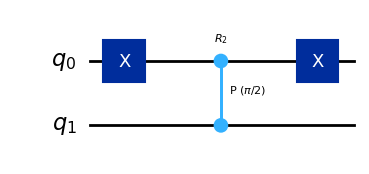

In [682]:
def sequential_coeff(j,f,N):
    # N = n_eigenvalue
    return f(j/N)

def sequential_operator(n,order,theta,nots=True):
    q = QuantumRegister(n,name='q')
    qc = QuantumCircuit(q)
    if order%2 == 0:
        binary = int_to_binary(order,n,reverse=False)
    else:
        binary = int_to_binary(order-1,n,reverse=False)
    if nots:
        if order%2 == 0:
            qc.x(q[0])
        for i in range(0,n-1):
            if binary[i] == '0':
                qc.x(q[n-i-1])
    if n > 1:
        gate = MCPhaseGate(theta,n-1,label='$R_{'+str(order)+'}$')
    else:
        gate = PhaseGate(theta,label='$R_{'+str(order)+'}$')
    qc.append(gate,qc.qubits)
    if nots:
        if order%2 == 0:
            qc.x(q[0])
        for i in range(0,n-1):
            if binary[i] == '0':
                qc.x(q[n-i-1])
    return qc

n = 2
order = 2
theta = np.pi/2
qc = sequential_operator(n,order,theta,nots=True)
qc.draw('mpl',style='iqx')

In [683]:
def sequential_informations(n,list_operator_to_implement,f,gray_code=True):
    sequential_dict = {}
    n_operator_to_implement = len(list_operator_to_implement)
    if gray_code:
        gray_list = generate_gray_code(n)
        for i in gray_list:
            if i in list_operator_to_implement:
                sequential_dict[i] = sequential_coeff(i,f,n_operator_to_implement)
    else:
        for i in range(n_operator_to_implement): 
            sequential_dict[list_operator_to_implement[i]] = sequential_coeff(list_operator_to_implement[i],f,n_operator_to_implement)
    return sequential_dict

In [684]:
def sequential_circuit(n,f,sequential_info,gray_code=True):
    q = QuantumRegister(n,name='q')
    qc = QuantumCircuit(q)
    sequential_operators_list = []
    order_list = list(sequential_info.keys())
    for order in order_list:
        if gray_code:
            sequential_operators_list.append(sequential_operator(n,order,sequential_info[order],nots=False))
        else:
            sequential_operators_list.append(sequential_operator(n,order,sequential_info[order]))
    for index,operator in enumerate(sequential_operators_list):
        if gray_code:
            # avoid putting the useless cnots
            if index == 0:
                nots_index = bits_to_zero(int_to_binary(order_list[index],n,reverse=True))
                for j in nots_index:
                    qc.x(q[j])
                qc.append(operator,qc.qubits)
            elif index > 0:
                current_index = int_to_binary(order_list[index],n,reverse=True)
                previous_index = int_to_binary(order_list[index-1],n,reverse=True)
                nots_index = changing_index(current_index,previous_index)
                for j in nots_index:
                    qc.x(q[j])
                qc.append(operator,qc.qubits)
            if index == len(sequential_operators_list)-1:
                nots_index = bits_to_zero(int_to_binary(order_list[index],n,reverse=True))
                for j in nots_index:
                    qc.x(q[j])
        else:
            qc.append(operator,qc.qubits)
            qc.barrier()
    return qc

{0: 0.0, 1: 0.0980171403295606, 2: 0.19509032201612825, 3: 0.29028467725446233, 4: 0.3826834323650898, 5: 0.47139673682599764, 6: 0.5555702330196022, 7: 0.6343932841636455, 8: 0.7071067811865475, 9: 0.773010453362737, 10: 0.8314696123025452, 11: 0.8819212643483549, 12: 0.9238795325112867, 13: 0.9569403357322089, 14: 0.9807852804032304, 15: 0.9951847266721968, 16: 1.0, 17: 0.9951847266721969, 18: 0.9807852804032304, 19: 0.9569403357322089, 20: 0.9238795325112867, 21: 0.881921264348355, 22: 0.8314696123025455, 23: 0.7730104533627371, 24: 0.7071067811865476, 25: 0.6343932841636455, 26: 0.5555702330196022, 27: 0.47139673682599786, 28: 0.3826834323650899, 29: 0.2902846772544624, 30: 0.1950903220161286, 31: 0.09801714032956083, 32: 1.2246467991473532e-16, 33: -0.09801714032956059, 34: -0.19509032201612836, 35: -0.2902846772544621, 36: -0.38268343236508967, 37: -0.47139673682599764, 38: -0.555570233019602, 39: -0.6343932841636453, 40: -0.7071067811865475, 41: -0.7730104533627367, 42: -0.83146

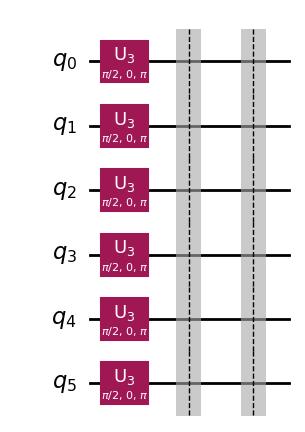

In [689]:
n = 6
list_operator_to_implement = [i for i in range(2**n)]
gray_code = False

q = QuantumRegister(n,name='q')
qc = QuantumCircuit(q)

qc.h(q)
qc.barrier()

sequential_info = sequential_informations(n,list_operator_to_implement,f2,gray_code=gray_code)
#qc.append(sequential_circuit(n,sequential_info,f2,gray_code=gray_code),qc.qubits)

qc.barrier()
qc.decompose(reps=2).draw('mpl',style='iqx')

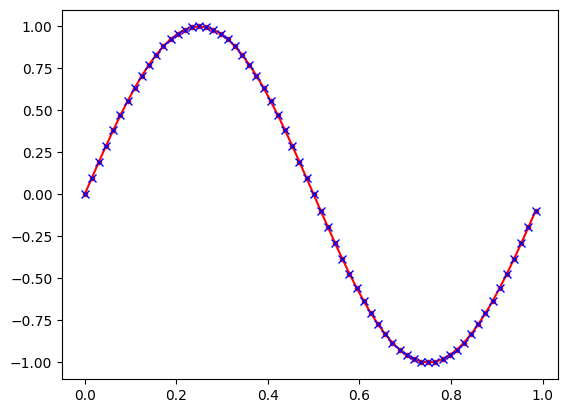

In [677]:
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

def f(x):
    return x

def f2(x):
    return np.sin(2*np.pi*x)

state = qi.Statevector.from_instruction(qc)

L = np.array(state.data[0:2**n])
L2 = np.angle(L)
X = np.array(range(2**n))/2**n

plt.plot(X,L2,marker='.',c='r')
plt.plot(X,f2(X),marker='x',c='b',linestyle='')
plt.show()

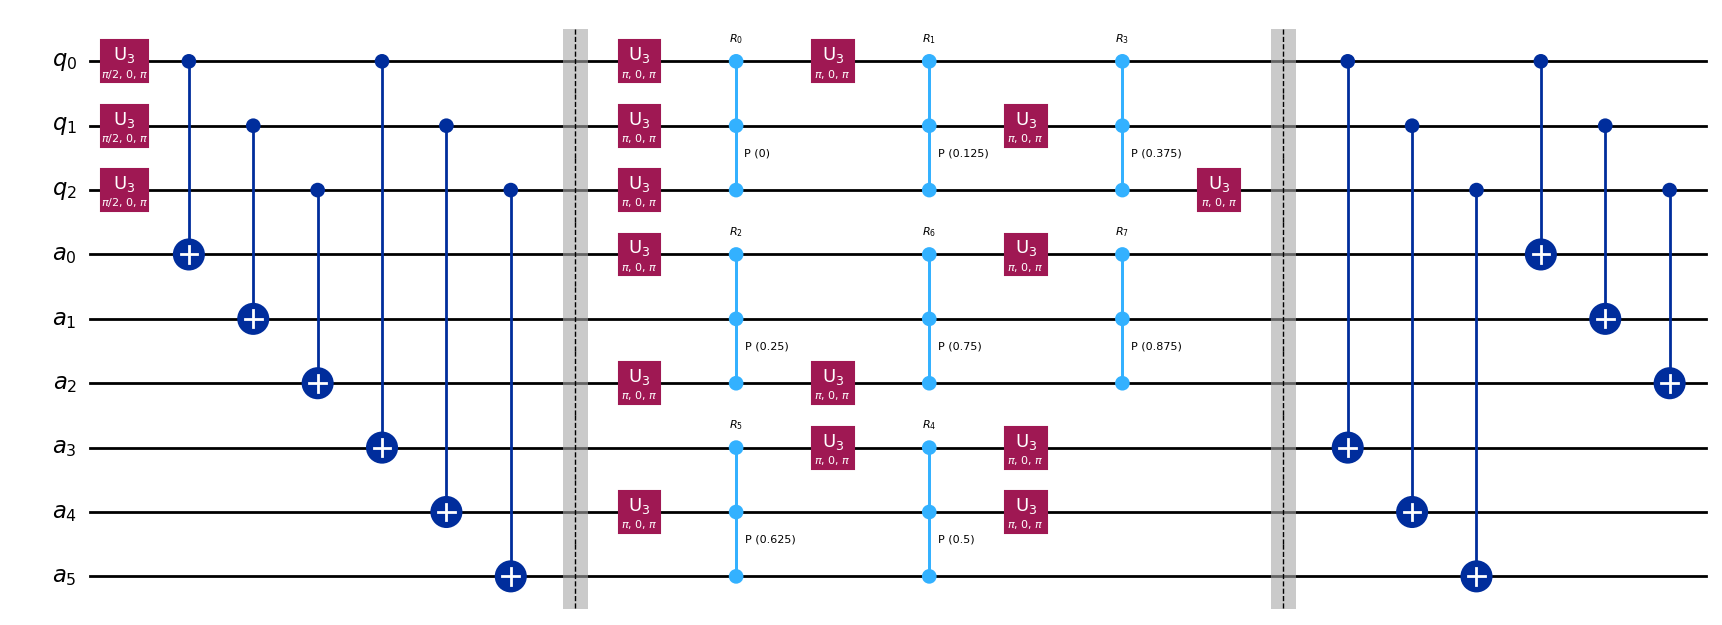

In [690]:
# Adjustable-sequential

# Adjustable-Walsh

n = 3
n_ancilla = 6
gray_code = True
list_operator_to_implement = [i for i in range(2**n)]
sequential_info = sequential_informations(n,list_operator_to_implement,f,gray_code=gray_code)

q = QuantumRegister(n,name='q')
a = QuantumRegister(n_ancilla,name='a')
qc = QuantumCircuit(q,a)

qc.h(q)

# copy of the main register into the ancilla register
if n_ancilla >= n:
    copy_gate = copy(q,a)
    qc.append(copy_gate,qc.qubits)
qc.barrier()

n_blocks = get_n_blocks(n,n_ancilla)
n_rotations = len(list_operator_to_implement)
n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
#print('n_blocks: ',n_blocks)
#print('n_operator_per_block: ',n_operator_per_block_list)

for i in range(0,n_blocks):
    sequential_info_block = dict(list(sequential_info.items())[:n_operator_per_block_list[i]])
    qc.append(sequential_circuit(n,f,sequential_info_block,gray_code=gray_code),qc.qubits[i*n:(i+1)*n])
    sequential_info = dict(list(sequential_info.items())[n_operator_per_block_list[i]:])

# uncompute the copy of the main register into the ancilla register
qc.barrier()
if n_ancilla >= n:
    qc.append(copy_gate.inverse(),qc.qubits)
    
qc.decompose(reps=2).draw('mpl',style='iqx')

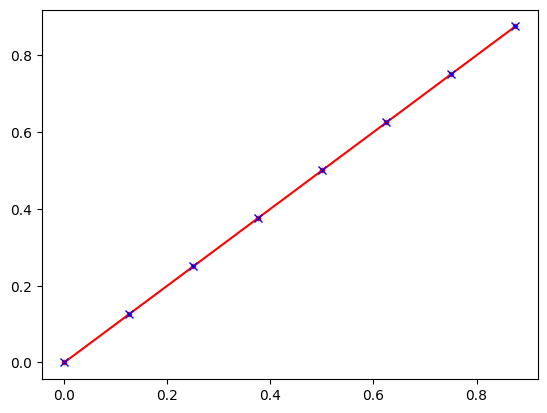

In [691]:
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

state = qi.Statevector.from_instruction(qc)

L = np.array(state.data[0:2**n])
L2 = np.angle(L)
X = np.array(range(2**n))/2**n

plt.plot(X,L2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')
plt.show()

## General framework

In [277]:
def walsh_informations(n,list_operator_to_implement,f,gray_code=True):
    """Returns a dictionnary whose keys are the order of Walsh functions to implement and the
    values are the associated coefficients
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    list_operator_to_implement : int list
        List of orders of the Walsh operators to implement
    f : function
        Function of one variable
    gray_code: bool
        Set to True if to get a gray code ordering of the orders of the Walsh operators
    Returns
    -------
    dict
    """
    walsh_dict = {}
    n_operator_to_implement = len(list_operator_to_implement)
    if gray_code:
        gray_list = generate_gray_code(n)
        for i in gray_list:
            if i in list_operator_to_implement:
                walsh_dict[i] = walsh_coeff(i,f,n_operator_to_implement)
    else:          
        for i in range(n_operator_to_implement):
            walsh_dict[list_operator_to_implement[i]] = walsh_coeff(list_operator_to_implement[i],f,n_operator_to_implement)
    return walsh_dict

list_operator_to_implement = [0,1,2,3,4,5,6,7]
walsh_info = walsh_informations(n,list_operator_to_implement,f,gray_code=False)
walsh_info[2], list(walsh_info.keys())

(-0.012503167819443356, [0, 1, 2, 3, 4, 5, 6, 7])

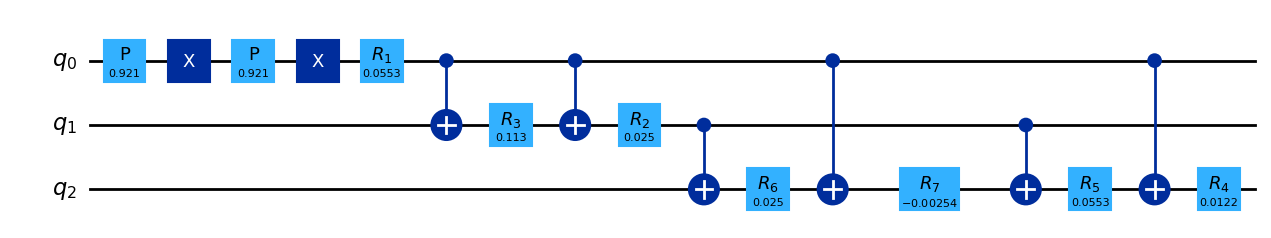

In [463]:
def walsh_circuit(n,f,walsh_info,gray_code=True):
    """Generates the quantum circuit implementing the Walsh decomposition of function f with the Walsh operators
        of order 
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    f : function
        Function of one variable
    walsh_info : dict
        Output of function walsh_informations, it is a dictionnary whose keys are the order of Walsh functions to implement and the
        values are the associated coefficients
    gray_code: bool
        Set to True if to get a gray code ordering of the orders of the Walsh operators
    Returns
    -------
    dict
    """
    q = QuantumRegister(n,name='q')
    qc = QuantumCircuit(q)
    walsh_operators_list = []
    order_list = list(walsh_info.keys())
    for order in order_list:
        if gray_code:
            walsh_operators_list.append(walsh_operator(n,order,walsh_info[order],cnots=False))
        else:
            walsh_operators_list.append(walsh_operator(n,order,walsh_info[order]))
    for index,operator in enumerate(walsh_operators_list):
        if gray_code:
            # avoid putting the useless cnots
            rotation_index = first_one_bit(int_to_binary(order_list[index],n,reverse=False))
            if index == 0:
                cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index])
                qc.append(operator,qc.qubits)
            elif index > 0:
                previous_cnots_index = other_one_bits(int_to_binary(order_list[index-1],n,reverse=False))
                current_cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                if len(previous_cnots_index) > len(current_cnots_index):
                    cnots_index = list(set(previous_cnots_index)-set(current_cnots_index))
                else:
                    cnots_index = list(set(current_cnots_index)-set(previous_cnots_index))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index])
                qc.append(operator,qc.qubits)
            if index == len(walsh_operators_list)-1:
                cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index]) 
        else:
            qc.append(operator,qc.qubits)
    return qc

def f(x):
    return np.exp(-(x-1/2)**2)

n = 3
list_operator_to_implement = [0,1,2,3,4,5,6,7]
gray_code = True
walsh_info = walsh_informations(n,list_operator_to_implement,f,gray_code=gray_code)
#print(walsh_info)
#qc = walsh_operator(n,7,walsh_coeffs,cnots=True)
qc = walsh_circuit(n,f,walsh_info,gray_code=gray_code)
qc.decompose(reps=1).draw('mpl',style='iqx')

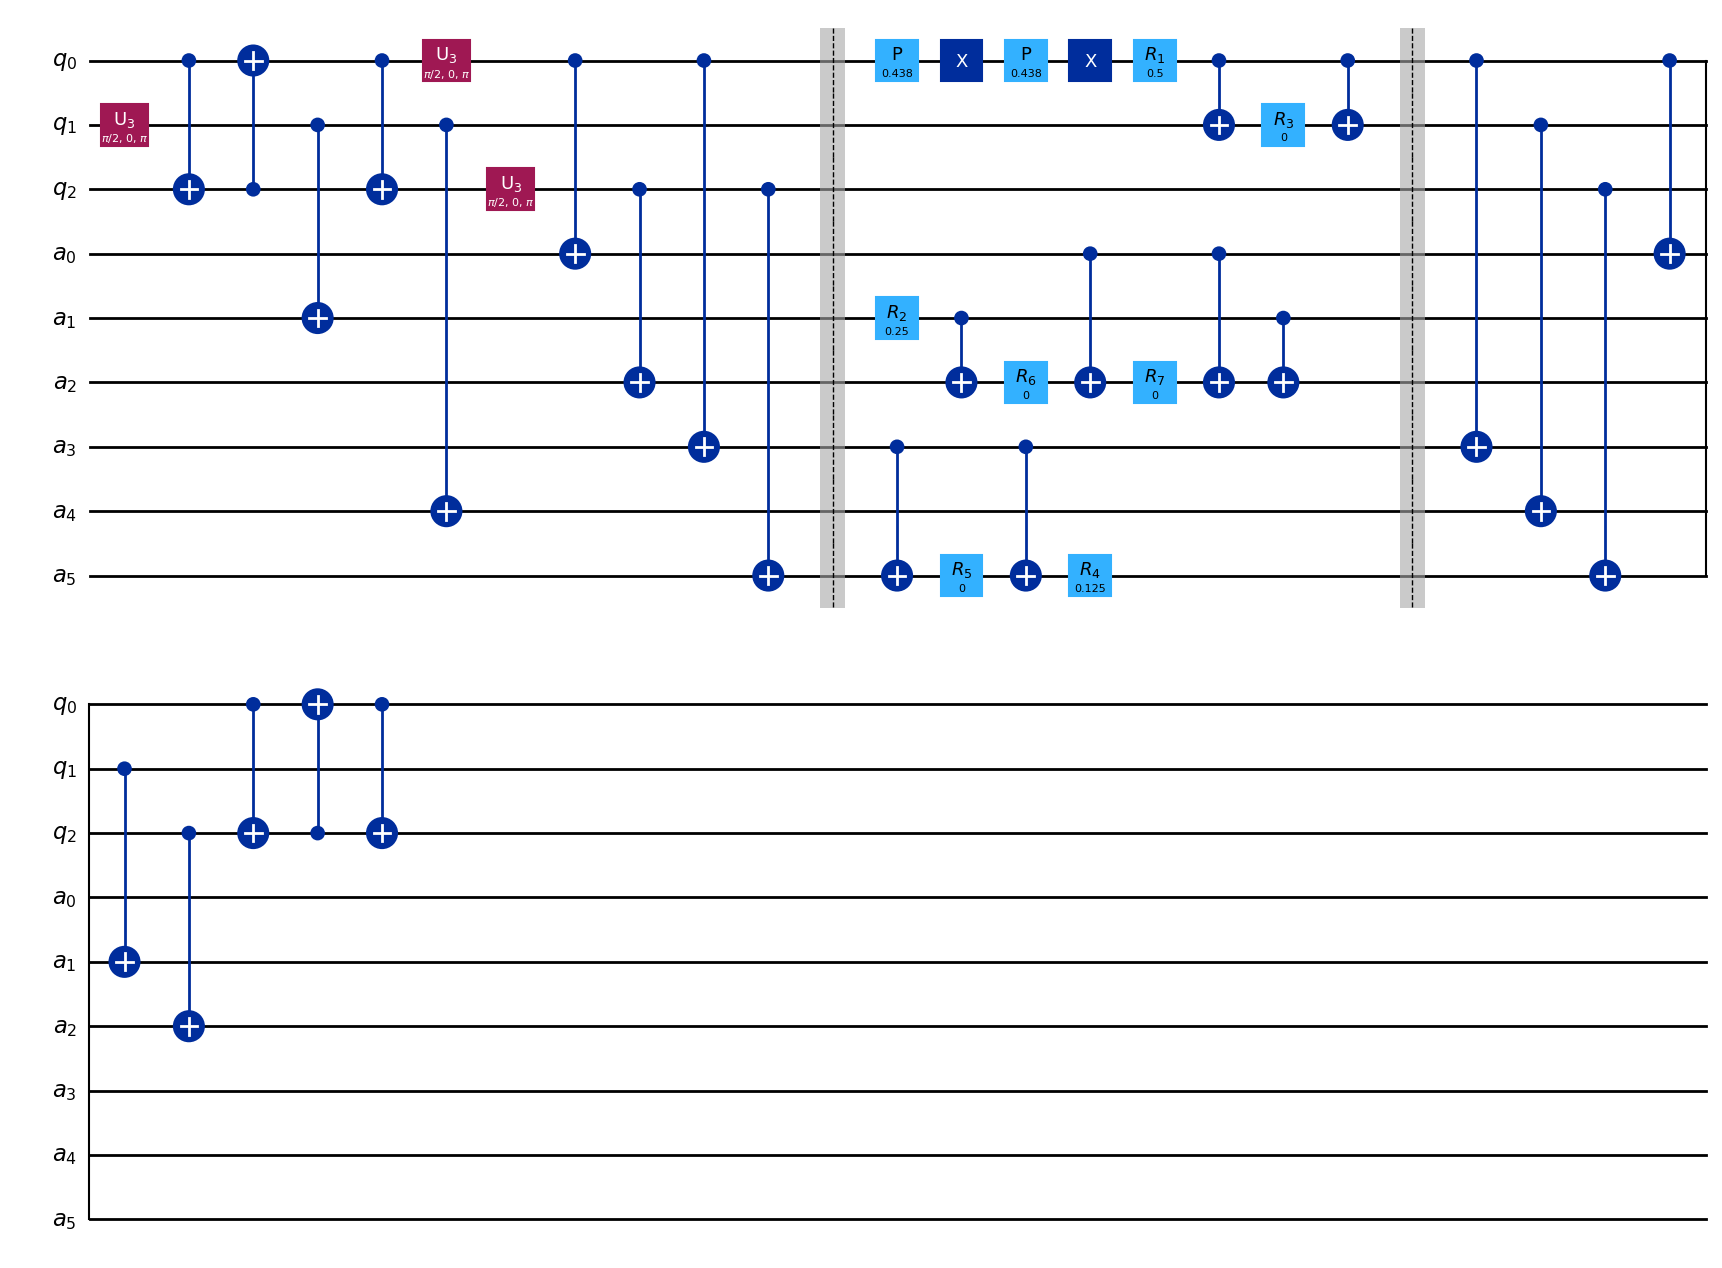

In [534]:
# Adjustable-Walsh

n = 3
n_ancilla = 6
gray_code = True
list_operator_to_implement = [i for i in range(2**n)]
walsh_info = walsh_informations(n,list_operator_to_implement,f,gray_code=gray_code)

q = QuantumRegister(n,name='q')
a = QuantumRegister(n_ancilla,name='a')
qc = QuantumCircuit(q,a)

for i in range(int(n/2)):
    qc.swap(q[i],q[n-i-1])
qc.h(q)

# copy of the main register into the ancilla register
if n_ancilla >= n:
    copy_gate = copy(q,a)
    qc.append(copy_gate,qc.qubits)
qc.barrier()

n_blocks = get_n_blocks(n,n_ancilla)
n_rotations = len(list_operator_to_implement)
n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
#print('n_blocks: ',n_blocks)
#print('n_operator_per_block: ',n_operator_per_block_list)

for i in range(0,n_blocks):
    walsh_info_block = dict(list(walsh_info.items())[:n_operator_per_block_list[i]])
    qc.append(walsh_circuit(n,f,walsh_info_block,gray_code=gray_code),qc.qubits[i*n:(i+1)*n])
    walsh_info = dict(list(walsh_info.items())[n_operator_per_block_list[i]:])

# uncompute the copy of the main register into the ancilla register
qc.barrier()
if n_ancilla >= n:
    qc.append(copy_gate.inverse(),qc.qubits)

for i in range(int(n/2)):
    qc.swap(q[i],q[n-i-1])
    
qc.decompose(reps=2).draw('mpl',style='iqx')

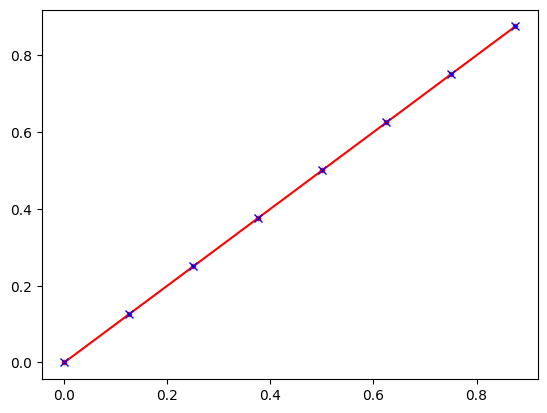

In [535]:
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

state = qi.Statevector.from_instruction(qc)

L = np.array(state.data[0:2**n])
L2 = np.angle(L)
X = np.array(range(2**n))/2**n

plt.plot(X,L2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')
plt.show()

### Non-used functions

In [439]:
def is_power_of_two(n):
    """Returns True is n if a power of two
    Parameters
    ----------
    n : int
        Positive integer

    Returns
    -------
    bool
    """
    return (n & (n-1) == 0) and n != 0

def all_bit_ones(b):
    """Returns the list of bit indices of b equal to 1
    Parameters
    ----------
    b : str
        Bit string
    Returns
    -------
    int list
    """
    one_bits = []
    for i in range(len(b)):
        if b[i] == '1':
            one_bits.append(i)
    return one_bits

def only_one(b):
    """Returns True if b has only one bit equal to 1
    Parameters
    ----------
    b : str
        Bit string
    Returns
    -------
    bool
    """
    n_ones = 0
    for i in range(len(b)):
        if b[i] == '1':
            n_ones += 1
    return n_ones == 1



def list_walsh_coeff(f,N):
    """List of the Walsh coefficient of the N-th Walsh series of f
    Parameters
    ----------
    f : function
        Function of one variable
    N : int
        Integer representing the number of points on which is computed the Walsh coefficient
    Returns
    -------
    float array  
    """
    coeff = []
    for j in range(N):
        coeff.append(walsh_coeff(j,f,N))
    return coeff

[1]*3

[1, 1, 1]